In [7]:
import pandas as pd
import numpy as np
import networkx as nx
import tweepy
import matplotlib.pyplot as plt
import sys
import json
sys.path.append("../")
from settings import APIKEY, APISECRETKEY, ACCESSTOKEN, ACCESSTOKENSECRET

In [6]:
tweets = pd.read_csv("../data/raw/article_tweets.csv")
claims = pd.read_pickle("../data/external/combined_data.pkl")
keywords = pd.read_csv("../data/external/all_keywords.csv")
organizations = pd.read_csv("../data/external/all_organisations.csv")

In [26]:
import requests

url = "https://api-hoaxy.p.rapidapi.com/articles"

querystring = {"query":"canonical_url:sputniknews.com\t","use_lucene_syntax":"false","sort_by":"relevant"}

headers = {
    'x-rapidapi-host': "api-hoaxy.p.rapidapi.com",
    'x-rapidapi-key': "4ae43af1f2mshf4db477a8729603p1bc1c5jsn4b8f903673bb"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

data = json.loads(response.text)

In [30]:
articles = []
for i in range(len(data["articles"])):

    articles.append(data["articles"][i]["id"])

In [57]:
url = "https://api-hoaxy.p.rapidapi.com/network"

querystring = {"ids":f"{articles}","nodes_limit":"1000","edges_limit":"12500","include_user_mentions":"true"}

headers = {
    'x-rapidapi-host': "api-hoaxy.p.rapidapi.com",
    'x-rapidapi-key': "4ae43af1f2mshf4db477a8729603p1bc1c5jsn4b8f903673bb"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

network = json.loads(response.text)

In [50]:
data

{'articles': [{'canonical_url': 'https://sputniknews.com/20211222/emergency-declared-on-nantes-porto-flight---tracker-1091725040.html',
   'date_published': '2022-01-12T00:00:00.000Z',
   'domain': 'sputniknews.com',
   'id': 2787775,
   'number_of_tweets': 8,
   'score': 34.360824585,
   'site_type': 'claim',
   'title': 'Emergency Declared on Nantes-Porto Flight - Tracker'},
  {'canonical_url': 'https://sputniknews.com/20211122/gazprom-issues-notice-to-moldova-on-gas-supplies-suspension-1090934917.html',
   'date_published': '2022-01-11T00:00:00.000Z',
   'domain': 'sputniknews.com',
   'id': 2735368,
   'number_of_tweets': 8,
   'score': 33.3860931396,
   'site_type': 'claim',
   'title': 'Gazprom Issues Notice to Moldova on Gas Supplies Suspension'},
  {'canonical_url': 'https://sputniknews.com/photo/202108081083556787/',
   'date_published': '2021-08-08T15:13:47.000Z',
   'domain': 'sputniknews.com',
   'id': 2556473,
   'number_of_tweets': 6,
   'score': 40.1282463074,
   'site_t

In [61]:
article_edges = []
for i in range(len(network["edges"])):
    article_edges.append(network['edges'][i]['title'])

In [64]:
article_edges

['Apocalypse Now: California Suffers From Disastrous Wildfires',
 'Two Russian Tu-160 Aircraft Perform Patrol in Belarusian Airspace - Video',
 'Gazprom Issues Notice to Moldova on Gas Supplies Suspension',
 '3 People Sustain Gunshot Wounds Amid Protests in Rotterdam',
 '3 People Sustain Gunshot Wounds Amid Protests in Rotterdam',
 '3 People Sustain Gunshot Wounds Amid Protests in Rotterdam',
 '3 People Sustain Gunshot Wounds Amid Protests in Rotterdam',
 'NHL Will Reportedly Miss Olympic Games Due to COVID-19',
 'Footage Captures Moment SUV Drove Through Christmas Parade in Wisconsin',
 'Footage Captures Moment SUV Drove Through Christmas Parade in Wisconsin',
 'Blinken Says Maduro Deprived Venezuelans of Free, Fair Elections in Sunday Vote',
 'Blinken Says Maduro Deprived Venezuelans of Free, Fair Elections in Sunday Vote',
 'Blinken Says Maduro Deprived Venezuelans of Free, Fair Elections in Sunday Vote',
 'Blinken Says Maduro Deprived Venezuelans of Free, Fair Elections in Sunday V

In [16]:
top_claim = tweets.claim.value_counts().keys()[0]
sample = tweets.loc[tweets.claim == top_claim]

In [77]:
sample.columns

Index(['claim', 'url', 'date', 'content', 'renderedContent', 'id',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'conversationId', 'lang', 'source', 'sourceUrl', 'sourceLabel',
       'outlinks', 'tcooutlinks', 'retweetedTweet', 'quotedTweet',
       'inReplyToTweetId', 'inReplyToUser', 'mentionedUsers', 'coordinates',
       'place', 'hashtags', 'cashtags', 'username', 'displayname',
       'description', 'rawDescription', 'descriptionUrls', 'verified',
       'created', 'followersCount', 'friendsCount', 'statusesCount',
       'favouritesCount', 'listedCount', 'mediaCount', 'location', 'protected',
       'linkUrl', 'linkTcourl', 'profileImageUrl', 'profileBannerUrl', 'label',
       'user_id'],
      dtype='object')

In [85]:
sample.loc[sample.retweetCount > 5].iloc[-1].url

'https://twitter.com/RT_com/status/1206134035338203136'

In [80]:
sample.loc[sample.mentionedUsers.notnull()]

,claim,url,date,content,renderedContent,id,replyCount,retweetCount,likeCount,quoteCount,...,listedCount,mediaCount,location,protected,linkUrl,linkTcourl,profileImageUrl,profileBannerUrl,label,user_id
179,OPCW has deliberately falsified Douma report t...,https://twitter.com/GordBolton/status/12065380...,2019-12-16 11:34:29+00:00,@CTVNews #uspoli #cdnpoli #pnpcbc #UKpolitics ...,@CTVNews #uspoli #cdnpoli #pnpcbc #UKpolitics ...,1206538079542005760,0.0,0.0,0.0,0.0,...,73.0,44416.0,NaN,False,NaN,NaN,https://pbs.twimg.com/profile_images/107872815...,https://pbs.twimg.com/profile_banners/22658856...,NaN,2265885618
203,OPCW has deliberately falsified Douma report t...,https://twitter.com/MuammarFidel/status/120629...,2019-12-15 19:46:15+00:00,@DerbyChrisW https://t.co/UDMFRu9jOT,@DerbyChrisW rt.com/news/475926-op…,1206299451377246208,0.0,0.0,0.0,0.0,...,0.0,10.0,NaN,False,NaN,NaN,https://pbs.twimg.com/profile_images/119691606...,NaN,NaN,1196914831636541440
213,OPCW has deliberately falsified Douma report t...,https://twitter.com/JohnDelacour/status/120626...,2019-12-15 17:18:36+00:00,#OPCW_FRAUD @OPCW \n#Douma_Hoax #SARIN_HOAX #S...,#OPCW_FRAUD @OPCW \n#Douma_Hoax #SARIN_HOAX #S...,1206262293056704512,2.0,1.0,4.0,0.0,...,97.0,14206.0,"Кронштадт, Санкт-Петербург",False,NaN,NaN,https://pbs.twimg.com/profile_images/939908688...,https://pbs.twimg.com/profile_banners/24622682...,NaN,2462268236
228,OPCW has deliberately falsified Douma report t...,https://twitter.com/friendofrussia/status/1206...,2019-12-15 15:23:48+00:00,@SulomeAnderson @bellingcat When the fingerpri...,@SulomeAnderson @bellingcat When the fingerpri...,1206233401453424640,0.0,0.0,2.0,0.0,...,7.0,213.0,United Kingdom,False,NaN,NaN,https://pbs.twimg.com/profile_images/142527726...,https://pbs.twimg.com/profile_banners/11331925...,NaN,1133192578247954432
229,OPCW has deliberately falsified Douma report t...,https://twitter.com/friendofrussia/status/1206...,2019-12-15 15:10:57+00:00,"@SenSanders ""Bashar Assad's chemical attack......","@SenSanders ""Bashar Assad's chemical attack......",1206230169884737536,0.0,0.0,0.0,0.0,...,7.0,213.0,United Kingdom,False,NaN,NaN,https://pbs.twimg.com/profile_images/142527726...,https://pbs.twimg.com/profile_banners/11331925...,NaN,1133192578247954432
238,OPCW has deliberately falsified Douma report t...,https://twitter.com/JamazingPal/status/1206185...,2019-12-15 12:15:09+00:00,"Hey @AIPAC, tell us who gave US intel report a...","Hey @AIPAC, tell us who gave US intel report a...",1206185927682543616,0.0,0.0,0.0,0.0,...,0.0,12.0,NaN,False,NaN,NaN,https://pbs.twimg.com/profile_images/117687703...,https://pbs.twimg.com/profile_banners/10670696...,NaN,1067069696636305408
246,OPCW has deliberately falsified Douma report t...,https://twitter.com/friendofrussia/status/1206...,2019-12-15 10:24:49+00:00,@whitehelmets90 https://t.co/9wnYWjJonX,@whitehelmets90 rt.com/news/475926-op…,1206158160148471808,0.0,0.0,0.0,0.0,...,7.0,213.0,United Kingdom,False,NaN,NaN,https://pbs.twimg.com/profile_images/142527726...,https://pbs.twimg.com/profile_banners/11331925...,NaN,1133192578247954432
253,OPCW has deliberately falsified Douma report t...,https://twitter.com/RT_com/status/120613403533...,2019-12-15 08:48:57+00:00,The team on the ground in #Douma was apparentl...,The team on the ground in #Douma was apparentl...,1206134035338203136,4.0,11.0,17.0,0.0,...,20749.0,184204.0,NaN,False,http://RT.com,https://t.co/gtHSJ8TMVD,https://pbs.twimg.com/profile_images/101883390...,https://pbs.twimg.com/profile_banners/64643056...,UserLabel(description='Russia state-affiliated...,64643056


In [76]:
sample.loc[sample.inReplyToUser.notnull()]

,claim,url,date,content,renderedContent,id,replyCount,retweetCount,likeCount,quoteCount,...,listedCount,mediaCount,location,protected,linkUrl,linkTcourl,profileImageUrl,profileBannerUrl,label,user_id
168,OPCW has deliberately falsified Douma report t...,https://twitter.com/AndyWu007/status/120681370...,2019-12-17 05:49:43+00:00,Contoh gampang hoax soal papua yg gunain senja...,Contoh gampang hoax soal papua yg gunain senja...,1206813705456898048,0.0,1.0,1.0,0.0,...,0.0,353.0,Singapore,False,NaN,NaN,https://pbs.twimg.com/profile_images/811923725...,https://pbs.twimg.com/profile_banners/81192209...,NaN,811922097748312064
179,OPCW has deliberately falsified Douma report t...,https://twitter.com/GordBolton/status/12065380...,2019-12-16 11:34:29+00:00,@CTVNews #uspoli #cdnpoli #pnpcbc #UKpolitics ...,@CTVNews #uspoli #cdnpoli #pnpcbc #UKpolitics ...,1206538079542005760,0.0,0.0,0.0,0.0,...,73.0,44416.0,NaN,False,NaN,NaN,https://pbs.twimg.com/profile_images/107872815...,https://pbs.twimg.com/profile_banners/22658856...,NaN,2265885618
203,OPCW has deliberately falsified Douma report t...,https://twitter.com/MuammarFidel/status/120629...,2019-12-15 19:46:15+00:00,@DerbyChrisW https://t.co/UDMFRu9jOT,@DerbyChrisW rt.com/news/475926-op…,1206299451377246208,0.0,0.0,0.0,0.0,...,0.0,10.0,NaN,False,NaN,NaN,https://pbs.twimg.com/profile_images/119691606...,NaN,NaN,1196914831636541440
228,OPCW has deliberately falsified Douma report t...,https://twitter.com/friendofrussia/status/1206...,2019-12-15 15:23:48+00:00,@SulomeAnderson @bellingcat When the fingerpri...,@SulomeAnderson @bellingcat When the fingerpri...,1206233401453424640,0.0,0.0,2.0,0.0,...,7.0,213.0,United Kingdom,False,NaN,NaN,https://pbs.twimg.com/profile_images/142527726...,https://pbs.twimg.com/profile_banners/11331925...,NaN,1133192578247954432
229,OPCW has deliberately falsified Douma report t...,https://twitter.com/friendofrussia/status/1206...,2019-12-15 15:10:57+00:00,"@SenSanders ""Bashar Assad's chemical attack......","@SenSanders ""Bashar Assad's chemical attack......",1206230169884737536,0.0,0.0,0.0,0.0,...,7.0,213.0,United Kingdom,False,NaN,NaN,https://pbs.twimg.com/profile_images/142527726...,https://pbs.twimg.com/profile_banners/11331925...,NaN,1133192578247954432
246,OPCW has deliberately falsified Douma report t...,https://twitter.com/friendofrussia/status/1206...,2019-12-15 10:24:49+00:00,@whitehelmets90 https://t.co/9wnYWjJonX,@whitehelmets90 rt.com/news/475926-op…,1206158160148471808,0.0,0.0,0.0,0.0,...,7.0,213.0,United Kingdom,False,NaN,NaN,https://pbs.twimg.com/profile_images/142527726...,https://pbs.twimg.com/profile_banners/11331925...,NaN,1133192578247954432


In [57]:
claims.loc[claims.claim == top_claim].links.values[0]

['https://www.rt.com/news/475926-opcw-leaks-report-syria-chemical/',
 'https://eadaily.com/ru/news/2019/12/15/daily-mail-poyavilis-novye-svidetelstva-feyka-o-himatake-asada-v-dume']

In [58]:
top_claim

'OPCW has deliberately falsified Douma report to blame the Assad Government'

In [61]:
claims

,date,claim,links,organizations,keywords,countries
0,2020-01-02T00:00:00+00:00,Ukraine does not want to buy gas from Russia b...,[https://russian.rt.com/ussr/article/704353-ga...,[russian.rt.com],"[gas, Oligarchs, Trade]","[Russia, Ukraine]"
1,2020-01-01T00:00:00+00:00,There is no freedom of speech in Estonia,[https://sputnik-news.ee/estonian_news/2020010...,[Sputnik Estonia],"[Dmitry Kiselyov, Sputnik, Sanctions]",[Estonia]
2,2019-12-31T00:00:00+00:00,The regime in Estonia publicly persecutes its ...,[https://sputnik-news.ee/estonian_news/2019123...,[Sputnik Estonia],"[Dmitry Kiselyov, Sputnik, Sanctions]",[Estonia]
3,2019-12-29T00:00:00+00:00,Poland started World War II,[],[],[WWII],[Poland]
4,2019-12-28T00:00:00+00:00,There are no lies coming from Sputnik,[https://sputnik-news.ee/estonian_news/2019122...,[Sputnik Estonia],"[Dmitry Kiselyov, Sputnik, Sanctions]",[Estonia]
...,...,...,...,...,...,...
7223,2015-03-11T00:00:00+00:00,Massive rally against NATO membership took pla...,[http://webcache.googleusercontent.com/search?...,[slobodnimediji.com],"[NATO, Vladimir Putin]","[Russia, Czech Republic]"
7224,2015-02-11T00:00:00+00:00,The migration crisis is a US-led operation wit...,[],[],"[Conspiracy, Migration crisis]","[US, EU]"
7225,2015-02-11T00:00:00+00:00,The Ukrainian revolution was organized by the ...,[http://www.casopis-sifra.cz/nikolaj-starikov-...,[Nikolai Starikov],[Euromaidan],"[US, Ukraine]"
7226,2015-01-25T00:00:00+00:00,There is a state-supported national tradition ...,[http://www.biosferaklub.info/co-se-na-nas-hrn...,"[czechfreepress.cz, biosferaklub.info// czechf...","[Stealing children, Perversion]",[Norway]


## Graph Embedding

In [18]:
from karateclub.dataset import GraphSetReader
from karateclub import FeatherGraph

reader = GraphSetReader("reddit10k")

graphs = reader.get_graphs()
y = reader.get_target()

model = FeatherGraph()
model.fit(graphs)
X = model.get_embedding()
X.shape

In [48]:
from sklearn.metrics.pairwise import cosine_similarity 
similarity = cosine_similarity(X)

0.789149999430017

In [49]:
similarity[0].argmin()

49

### Graph most different from the first graph 

They are classified differently in the dataset which is promising

In [59]:
y[0]

0

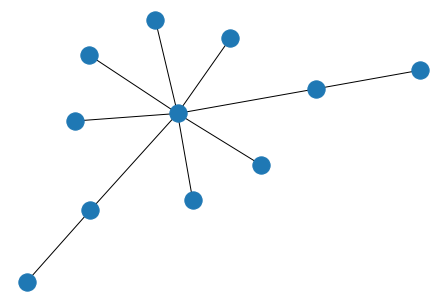

In [55]:
nx.draw(graphs[0])

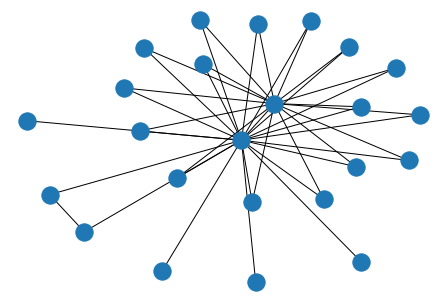

In [54]:
nx.draw(graphs[49])

In [58]:
y[49]

1